In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

mpl.rc('font', **font)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from datetime import datetime

In [36]:
# importing the Train and Test CSV files
train_data = pd.read_csv('F:/Datasets/ML proj/train.csv')
test_data = pd.read_csv('F:/Datasets/ML proj/test.csv')

In [37]:
# finding number of True'1'/false'0' values under each labels in the training dataset - Analyzing the dataset
valCount = (train_data.iloc[:, 2:8]).apply(pd.value_counts)
valCount.sort_values(by=1, ascending=True, axis=1, inplace=True)
valCount

,threat,identity_hate,severe_toxic,insult,obscene,toxic
0,159093,158166,157976,151694,151122,144277
1,478,1405,1595,7877,8449,15294


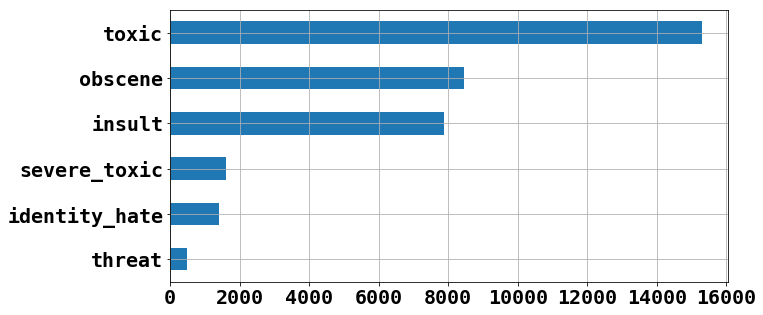

In [41]:
# plotting only the True'1' values under each labels in training dataset
valCount.loc[1].plot.barh(figsize=(10,5)).grid()

In [39]:
# extracting comment_text column from train and test for vectorizing
trainComTxt = train_data['comment_text']
testComTxt = test_data['comment_text']
fullTxt = pd.concat([trainComTxt,testComTxt])

In [8]:
# creating pipeline for TF-IDF vectorizer and Logistic Regression class for Grid search CV
txt_clf = Pipeline([('tfidfvec', TfidfVectorizer(analyzer='word',stop_words='english',use_idf=True,smooth_idf=True)),
                    ('lr',LogisticRegression())])

In [9]:
# setting possible hyper parameters for TF-IDF and Logistic regression for Grid search CV
params = {'tfidfvec__sublinear_tf': (True, False),'tfidfvec__ngram_range': [(1,1),(1,2)],'tfidfvec__max_features': (20000,30000),'lr__solver':('sag','saga'),'lr__C':(10,12)}

In [10]:
# creating Grid search CV object with pipeline and params
gs_clf = GridSearchCV(txt_clf, params, n_jobs=2)

In [11]:
# As Grid search CV takes enomorous amount of time to validate entire traing data which is almost 150k records So validating with 1000 records.
gstrain = train_data.iloc[:20000,1]
gstrain.head
gstar = train_data.iloc[:20000, 2:8]
gstar.head

<bound method DataFrame.head of        toxic  severe_toxic  obscene  threat  insult  identity_hate
0          0             0        0       0       0              0
1          0             0        0       0       0              0
2          0             0        0       0       0              0
3          0             0        0       0       0              0
4          0             0        0       0       0              0
5          0             0        0       0       0              0
6          1             1        1       0       1              0
7          0             0        0       0       0              0
8          0             0        0       0       0              0
9          0             0        0       0       0              0
10         0             0        0       0       0              0
11         0             0        0       0       0              0
12         1             0        0       0       0              0
13         0             0    

In [12]:
# labels in list for iteration
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [20]:
# Grid search CV for all label and find best score and best param for respective labels
for label in labels:
    targ = gstar[label]
    strTm = datetime.now()
    gs_clf = gs_clf.fit(gstrain, targ)
    bestScore = gs_clf.best_score_
    bestParam = gs_clf.best_params_
    difTm = (datetime.now()-strTm)
    msg = "For %s, Best Params: %s and Best Score:%f, Time taken:%s sec." % (label,str(bestParam),bestScore,str(difTm.seconds))
    print msg

For toxic, Best Params: {'tfidfvec__sublinear_tf': True, 'lr__solver': 'sag', 'tfidfvec__max_features': 20000, 'lr__C': 12, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.950900, Time taken:354 sec.
For severe_toxic, Best Params: {'tfidfvec__sublinear_tf': False, 'lr__solver': 'saga', 'tfidfvec__max_features': 30000, 'lr__C': 10, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.989500, Time taken:377 sec.
For obscene, Best Params: {'tfidfvec__sublinear_tf': True, 'lr__solver': 'saga', 'tfidfvec__max_features': 20000, 'lr__C': 12, 'tfidfvec__ngram_range': (1, 2)} and Best Score:0.975350, Time taken:350 sec.
For threat, Best Params: {'tfidfvec__sublinear_tf': True, 'lr__solver': 'sag', 'tfidfvec__max_features': 20000, 'lr__C': 10, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.996700, Time taken:378 sec.
For insult, Best Params: {'tfidfvec__sublinear_tf': True, 'lr__solver': 'sag', 'tfidfvec__max_features': 30000, 'lr__C': 10, 'tfidfvec__ngram_range': (1, 1)} and Best Score:0.9642

In [21]:
# TFidf vectorizer with best param identified from Grid search CV
tfidf = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, analyzer='word', use_idf=True, ngram_range=(1, 1),stop_words="english", max_features=30000)

In [22]:
# Fit and Tranform comment texts into TF-IDF vectors for train and test data
tfidf.fit(fullTxt)
trainFeat = tfidf.transform(trainComTxt)
testFeat = tfidf.transform(testComTxt)

In [23]:
trainFeat.shape

(159571, 30000)

In [24]:
testFeat.shape

(153164, 30000)

In [25]:
trainFeat.data

array([ 0.18517584,  0.19787236,  0.20985647, ...,  0.23659496,
        0.37105798,  0.3908023 ])

In [26]:
testFeat.data

array([ 0.1573735 ,  0.10258018,  0.21704905, ...,  0.33580749,
        0.45597579,  0.40973187])

In [27]:
# Cross validation with roc_auc scoring with Logistic Regression model parameters identified by Grid Search CV
for label in labels:
    trainTarg = train_data[label]
    cv = cross_val_score(LogisticRegression(solver='saga', C=10),trainFeat,trainTarg, cv=10, scoring='roc_auc')
    score = cv.mean()
    msg = "%s: %f" % (label, score)
    print msg

toxic: 0.967591
severe_toxic: 0.978107
obscene: 0.981942
threat: 0.982534
insult: 0.970828
identity_hate: 0.969396


In [28]:
# dataframe to store predicted probabilities
predResults = pd.DataFrame.from_dict({'Comment': test_data['comment_text']})

In [29]:
# Using Logistic Regression model, fitting the training data for all labels & predicting probabilities for test data
for label in labels:
     trainTarg = train_data[label]
     lrClf = LogisticRegression(solver='saga', C=10)
     lrClf.fit(trainFeat,trainTarg)
     predResults[label] = lrClf.predict_proba(testFeat)[:,1]
     debugMsg = "Prediction completed for %s label" %label
     print debugMsg

Prediction completed for toxic label
Prediction completed for severe_toxic label
Prediction completed for obscene label
Prediction completed for threat label
Prediction completed for insult label
Prediction completed for identity_hate label


In [30]:
# validating size of predicted results
predResults.shape

(153164, 7)

In [31]:
predResults.head()

,Comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,0.999827,0.114732,0.999744,0.022665,0.920502,0.222626
1,== From RfC == \n\n The title is fine as it is...,0.001257,0.000571,0.000366,0.000518,0.002179,0.000670
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.014121,0.000909,0.004151,0.000301,0.007472,0.001377
3,":If you have a look back at the source, the in...",0.000658,0.001409,0.001062,0.000173,0.001873,0.000042
4,I don't anonymously edit articles at all.,0.004382,0.001087,0.001423,0.000946,0.002213,0.000600


In [32]:
# saving the predicted results as csv file
predResults.to_csv('LR_Prediction.csv',index=False)